
# Project: Investigate Absence of Patients

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects informationfrom 100k medical appointments inBrazil and is focused on the questionof whether or not patients show upfor their appointment. Appointment details are given to us. Various factors which could have a possbile relation with the absence of a patient is also given.

We have to find out that whether any factor have a realtion with the absence of patient on appointment day. Possible factors ,analysed in this report, which can have a realtion with the absence of patients are:-  
* Is there any realtion between age of patients and their absence?
* Does timegap between scheduleday and appointment day have any impact on presence of patient?
* Which group, male or female, is more likely to absent?
* Any difference in presence of patients to whom SMS was sent?
* Relation between severity of handicapness and patients's absence?
* Is there any particular weekday where patients are more likely to absent?
* Is there any realtionship between age group and number of diseases that a patient have?

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [53]:
# load data
df = pd.read_csv('data/noshowappointments-kagglev2-may-2016.csv')

In [54]:
# Overview of data
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [55]:
# Checking data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [56]:
# Is there any Number of duplicate rows
sum(df.duplicated())

0

In [57]:
#  number of rows that have null values
df.isna().any().sum()

0

In [58]:
# Number of unique values every column have
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64


### Renaming columns
Because we don't want to remember whether column name contain upper or lower letter we are converting every alphabet in lower case for consistency

In [59]:
# lowercasing every coulumn name
df.rename(columns=lambda x: x.lower(),inplace=True)

In [60]:
df.columns

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no-show'],
      dtype='object')

### Changing datatype in columns 
There are two columns containing dates but we can't perform date operations on them because they not of datetime data type.

In [61]:
# Cheking data type of current dates columns
[type(df[x][0]) for x in ['scheduledday','appointmentday']]

[str, str]

In [62]:
# Changing into datetime format
for x in ['scheduledday','appointmentday']:
    df[x]=pd.to_datetime(df[x])

In [63]:
# Cheking data type of current dates columns
[type(df[x][0]) for x in ['scheduledday','appointmentday']]

[pandas._libs.tslibs.timestamps.Timestamp,
 pandas._libs.tslibs.timestamps.Timestamp]

No-show column contain yes or no values. But it will be easier to do operations on boolean values so let's convert them in boolean data type.

In [64]:
# Change no-show column data type in Boolean
df['no-show']=df['no-show'].map({'Yes':True,'No':False})

### Adding columns for our analysis
We require some further columns for data analysis. Let's add them

First, we require timegap column becuase we want to analyse the timegap between appointment and scheduled date with absence of patients.

In [65]:
# Difference between appointment date and scheduledday
df['timegap']=df['appointmentday'].dt.date-df['scheduledday'].dt.date

In [66]:
# Adding day of week(dow) on Appointment day column
df['dow_appoinment']=df['appointmentday'].dt.day_name()

In [67]:
# We require number_disease column because we want to get the realtionship between age_groups and this.

In [68]:
# Number of disease from the given name of disease in data
df['number_disease']=df.loc[:,['hipertension','diabetes','alcoholism']].sum(axis=1)

### Removing extra columns
Removing those columns which are not important for further analysis

In [69]:
df.drop(['patientid', 'appointmentid', 'scheduledday',
       'appointmentday', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism'],axis=1,inplace=True)

In [70]:
# let's have a look at data now
df.head()

,gender,age,handcap,sms_received,no-show,timegap,dow_appoinment,number_disease
0,F,62,0,0,False,0 days,Friday,1
1,M,56,0,0,False,0 days,Friday,0
2,F,62,0,0,False,0 days,Friday,0
3,F,8,0,0,False,0 days,Friday,0
4,F,56,0,0,False,0 days,Friday,2


### Checking possible human errors
Before processing further on data we should find whether there is any absurdness in data

In [71]:
# let's check the statistical summary of data
df.describe()

,age,handcap,sms_received,timegap,number_disease
count,110527.000000,110527.000000,110527.000000,110527,110527.000000
mean,37.088874,0.022248,0.321026,10 days 04:24:31.828602,0.299511
std,23.110205,0.161543,0.466873,15 days 06:07:11.673762,0.597655
min,-1.000000,0.000000,0.000000,-6 days +00:00:00,0.000000
25%,18.000000,0.000000,0.000000,0 days 00:00:00,0.000000
50%,37.000000,0.000000,0.000000,4 days 00:00:00,0.000000
75%,55.000000,0.000000,1.000000,15 days 00:00:00,0.000000
max,115.000000,4.000000,1.000000,179 days 00:00:00,3.000000


There are two things which needs further attention:-
* Age less than 0
* timegap in -ve

If there are only a few of them then we can drop these observation because seems to be appear because of human error

In [72]:
# Number of rows where age is less than 0
sum(df['age']<0)

1

In [73]:
# Number of rows where timegap between appointment date and scheduled date is -ve
sum(df['timegap'].dt.days<0)

5

In [74]:
# Number of rows before dropping
df.shape[0]

110527

In [75]:
# Dropping rows 
df.drop(df[df['age']<0].index,inplace=True)
df.drop(df[df['timegap'].dt.days<0].index,inplace=True)

In [76]:
# Number of rows before dropping
df.shape[0]

110521

In [77]:
# Number of rows where age is less than 0
sum(df['age']<0)

0

In [78]:
# Number of rows where timegap between appointment date and scheduled date is -ve
sum(df['timegap'].dt.days<0)

0

### Categorising data
Analysis will be more effective if we categorise our data of age and timegap 

Let's divide age column in 4 categories of ages

In [79]:
# Categorising age data in 4 age_groups
df['age_group']=pd.cut(df['age'],[0,10,25,50,115],labels=['Below 10','10-25','25-50','above 50'],include_lowest=True)

Let's divide timegap column in 6 categories because it will be earsier to make comparison when we will have different categories

In [80]:
# Categorising timegap in months
df['timegap_months']=pd.cut(df['timegap'].dt.days,[0,30,60,90,120,150,180],labels=['1','2','3','4','5','6'],include_lowest=True)

Becasuse we have taken the categories of the columns the respective column are no longer needed

In [81]:
# Dropping columns
df.drop(['age','timegap'],axis=1,inplace=True)

In [82]:
# Let's have a look at data structure now
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   gender          110521 non-null  object  
 1   handcap         110521 non-null  int64   
 2   sms_received    110521 non-null  int64   
 3   no-show         110521 non-null  bool    
 4   dow_appoinment  110521 non-null  object  
 5   number_disease  110521 non-null  int64   
 6   age_group       110521 non-null  category
 7   timegap_months  110521 non-null  category
dtypes: bool(1), category(2), int64(3), object(2)
memory usage: 5.4+ MB


In [83]:
# A quick snap of our data
df.head()

,gender,handcap,sms_received,no-show,dow_appoinment,number_disease,age_group,timegap_months
0,F,0,0,False,Friday,1,above 50,1
1,M,0,0,False,Friday,0,above 50,1
2,F,0,0,False,Friday,0,above 50,1
3,F,0,0,False,Friday,0,Below 10,1
4,F,0,0,False,Friday,2,above 50,1


<a id='eda'></a>
## Exploratory Data Analysis

Now our data is ready for analysis. From now we will try to answers all the questions we make at introduction stage
### Is there any realtion between age of patients and their absence
Here we want to analyse whether childeren, young or old people have more tendency to be late.

In [84]:
# Total patients in each group
total_patients=df['age_group'].value_counts()

In [85]:
# Number of absent patients in each group
absent_patients=df.groupby('age_group')['no-show'].sum()

In [86]:
# Proportion of absent patient in each group
absent_prop=absent_patients/total_patients
absent_prop

Below 10    0.201995
10-25       0.253325
25-50       0.212941
above 50    0.161651
dtype: float64

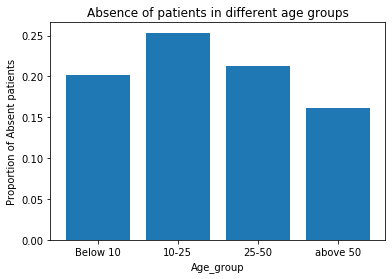

In [87]:
plt.bar(absent_prop.index,absent_prop)
plt.title('Absence of patients in different age groups')
plt.xlabel('Age_group')
plt.ylabel('Proportion of Absent patients');

From this data we can say that Patients within Age group 10-25 have maximum proportion of absence. Whereas old patients are least likely to absent.

### Does timegap between scheduleday and appointment day have any impact on presence of patient?
Since there are possibilities that the appointment which is far away can be off the chart from any person's calender. As the time increases chances are patient didn't take appiointment seriously. Let's look at the data to check our hypothesis.

In [88]:
# Total patients in each group
total_patients=df['timegap_months'].value_counts()

In [89]:
# Number of absent patients in each group
absent_patients=df.groupby('timegap_months')['no-show'].sum()

In [90]:
# Proportion of absent patient in each group
absent_prop=absent_patients/total_patients
absent_prop

1    0.188620
2    0.341543
3    0.287540
4    0.204545
5    0.379310
6    0.321429
dtype: float64

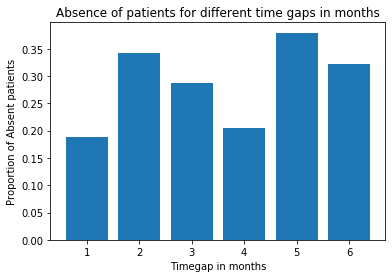

In [91]:
plt.bar(absent_prop.index,absent_prop)
plt.title('Absence of patients for different time gaps in months')
plt.xlabel('Timegap in months')
plt.ylabel('Proportion of Absent patients');

Appointment date which are within one month of scheduled date have most chances that patient will present. There is not a positive correlation between timegap and absence but timegap of 5-6 months are showing comparitively more chances of absennce.

### Which group, male or female, is more likely to absent
This is just a random experiment that whether there is any realtionship between a person's gender and his/her habit of getting late.

In [92]:
# Total patients in each group
total_patients=df['gender'].value_counts()

In [93]:
# Number of absent patients in each group
absent_patients=df.groupby('gender')['no-show'].sum()

In [94]:
# Proportion of absent patient in each group
absent_prop=absent_patients/total_patients
absent_prop

gender
F    0.203115
M    0.199638
dtype: float64

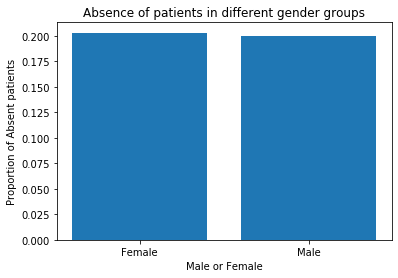

In [95]:
plt.bar(absent_prop.index,absent_prop)
plt.xticks(absent_prop.index,['Female','Male'])
plt.title('Absence of patients in different gender groups')
plt.xlabel('Male or Female')
plt.ylabel('Proportion of Absent patients');

It doesn't make a difference that a patient is male or female. He/she has equal chances of absence.

### Any difference in presence of patients to whom SMS was sent?
One possibililty is that the patients who got message will not be absent on the appointment day. Let's check whether it's true or not.

In [96]:
# Total patients in each group
total_patients=df['sms_received'].value_counts()

In [97]:
# Number of absent patients in each group
absent_patients=df.groupby('sms_received')['no-show'].sum()

In [98]:
# Proportion of absent patient in each group
absent_prop=absent_patients/total_patients
absent_prop

sms_received
0    0.166980
1    0.275745
dtype: float64

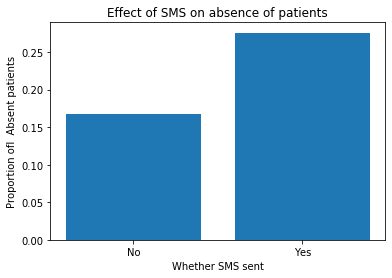

In [99]:
plt.bar(absent_prop.index,absent_prop)
plt.xticks(absent_prop.index,['No','Yes'])
plt.title('Effect of SMS on absence of patients')
plt.xlabel('Whether SMS sent')
plt.ylabel('Proportion ofl  Absent patients');

Sending SMS shows negative impact on presence. Patients who received SMS are more likely of absent.

### Relation between severity of handicapness and patients's absence?
There can a possibility that a handicape person may not be able to show up on the day of appointment becase of some physical issue. let's check it

In [100]:
# Total patients in each group
total_patients=df['handcap'].value_counts()

In [101]:
# Number of absent patients in each group
absent_patients=df.groupby('handcap')['no-show'].sum()

In [102]:
# Proportion of absent patient in each group
absent_prop=absent_patients/total_patients
absent_prop

handcap
0    0.202333
1    0.178431
2    0.202186
3    0.230769
4    0.333333
dtype: float64

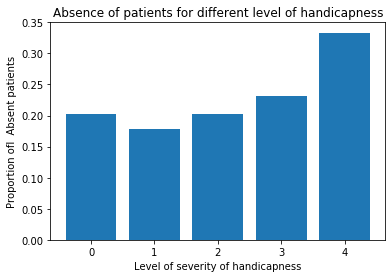

In [103]:
plt.bar(absent_prop.index,absent_prop)
plt.title('Absence of patients for different level of handicapness')
plt.xlabel('Level of severity of handicapness')
plt.ylabel('Proportion ofl  Absent patients');

Absence of patient and his severity of handicapness is positively correlated.

### Is there any particular weekday where patients are more likely to absent?
We all know how much lazy we are on saturday and how much busy we are on monday. Let's check wheter we found some realtion here to prove that human nature.

In [104]:
# Total patients in each group
total_patients=df['dow_appoinment'].value_counts()

In [105]:
# Number of absent patients in each group
absent_patients=df.groupby('dow_appoinment')['no-show'].sum()

In [106]:
# Proportion of absent patient in each group
order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
absent_prop=absent_patients/total_patients
absent_prop

Friday       0.212261
Monday       0.206446
Saturday     0.230769
Thursday     0.193494
Tuesday      0.200874
Wednesday    0.196861
dtype: float64

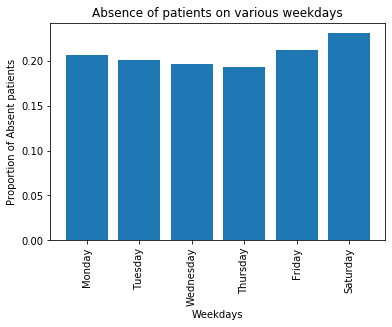

In [107]:
plt.bar(order,absent_prop[order])
plt.xticks(rotation=90)
plt.title('Absence of patients on various weekdays')
plt.xlabel('Weekdays')
plt.ylabel('Proportion of Absent patients');

Patients are more likely to be absent on Saturday i.e. weekend.

### Is there any realtionship between age group and number of diseases that a patient have?
We know that people from higher age_group are tend to be infected from more disease. So let's find out whether we can find any obvious realtionsip here.

In [108]:
# Average number of disease people in different age groups
disease_age_group=df.groupby('age_group')['number_disease'].mean()

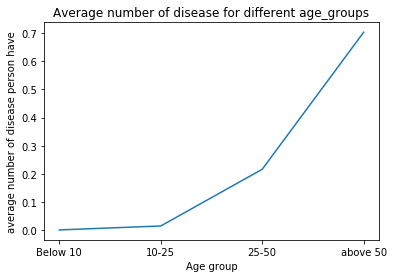

In [109]:
plt.plot(disease_age_group.index,disease_age_group)
plt.xlabel('Age group')
plt.ylabel('average number of disease person have')
plt.title('Average number of disease for different age_groups');

As we all know the obvious realtion between age and disease, our data is also obvious here. It is clearly showing that how age group of old people have the highest average number of disease.

## Limitations
There are some error in data as we found out at the stage of data cleaning. Like:-
* age of someone is given in -ve which is not possible.
* in some cases date of appointment is before scheduled date. It is natural that if that's the case then it is obvious that patient will be absent on appointment date.
It seems like these are human error and because these don't effect many observations we removed them to clean analysis. But results may be different if the data is accurate.

<a id='conclusions'></a>
## Conclusions


* Patients within Age group 10-25 have maximum proportion of absence. Whereas old patients are least likely to absent.
* Appointment date which are within one month of scheduled date have most chances that patient will present. There is not a positive correlation between timegap and absence but timegap of 5-6 months are showing comparitively more chances of absennce.
* It doesn't make a difference that a patient is male or female. He/she has equal chances of absence.
* Sending SMS shows negative impact on presence. Patients who received SMS are more likely of absent.
* Absence of patient and his severity of handicapness is positively correlated.
* Patients are more likely to be absent on Saturday i.e. weekend.
* As we all know the obvious realtion between age and disease, our data is also obvious here. It is clearly showing that how age group of old people have the highest average number of disease.